# DATA MASTERS
### Prognozowanie zapotrzebowania na energię elektryczną w ramach gospodarstwa domowego

### Zmienne

**date:** data w formacie dd/mm/yyyy

**time:** czas w formacie hh:mm:ss

**globalactivepower:** globalna moc czynna dla gospodarstwa domowego (w kilowatach, uśrednione w minutach)

**submetering1:** podlicznik energii nr 1 (w watogodzinach energii czynnej). Odpowiada kuchni, składającej się ze zmywarki, piekarnika i kuchenki mikrofalowej (płyty grzewcze nie są elektryczne, lecz gazowe)

**submetering2:** podlicznik energii nr 2 (w watogodzinach energii czynnej). Odpowiada pralni, w której znajduje się pralka, suszarka bębnowa, lodówka i oświetlenie

**submetering3:** podlicznik energii nr 3 (w watogodzinach energii czynnej). Odpowiada elektrycznemu podgrzewaczowi wody i klimatyzatorowi











In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime

%matplotlib inline
sns.set()
from IPython.display import Image

In [2]:
# ! pip install pmdarima # jeśli nie ma zainstalowanego to trzeba odpalić

In [3]:
! pip install pmdarima

In [4]:
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("household_power_consumption.txt", sep=";", low_memory = False)
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0


In [6]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

# Wizualizacja zużycia prądu

#### Wizualizacja wszystkich danych jest po lewej stronie, dane bez outlierów są po stronie prawej

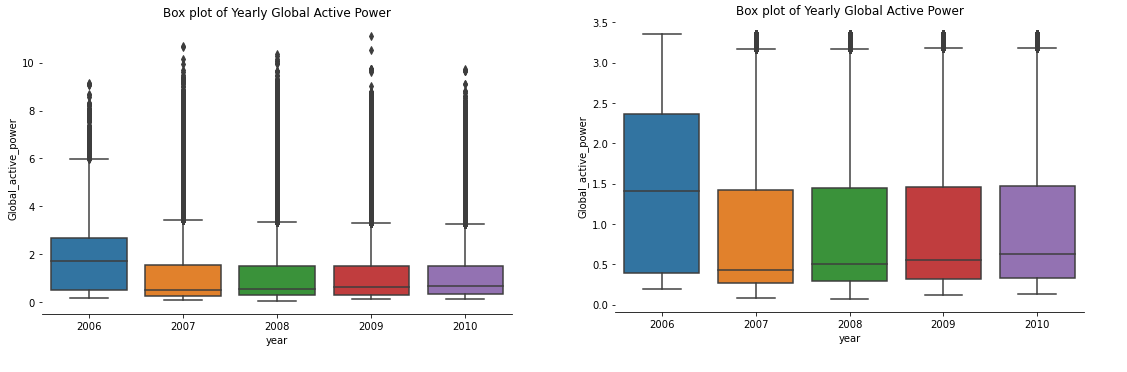

In [7]:
Image("yearlyfin.png")

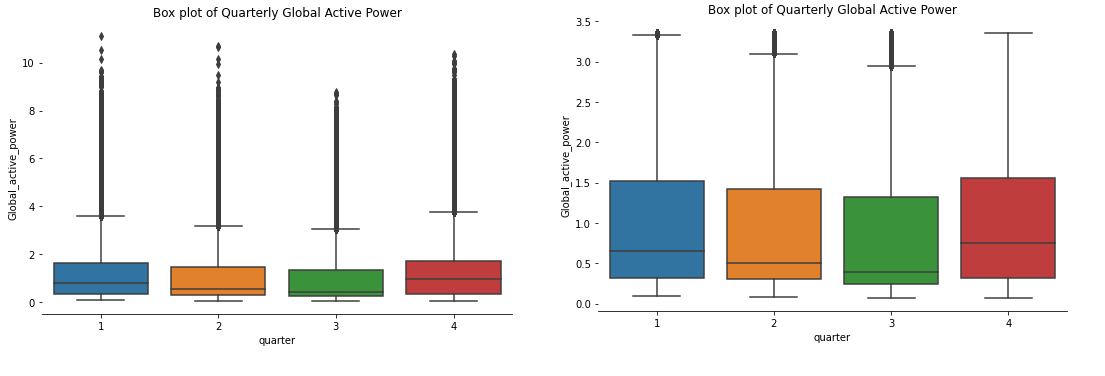

In [8]:
Image("quaterfin.png")

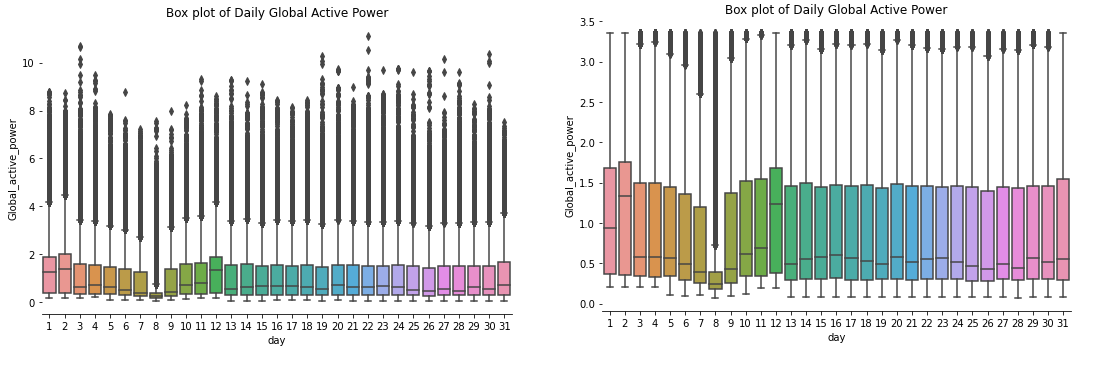

In [9]:
Image("dailyfin.png")

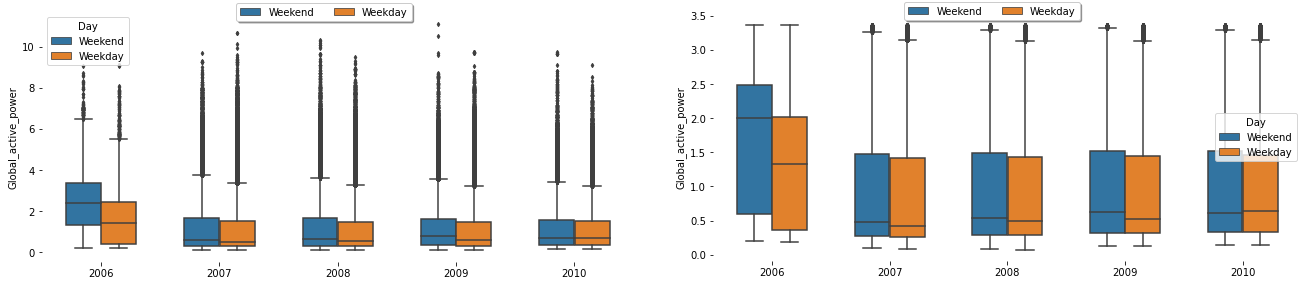

In [10]:
Image("weekendsfin.png")

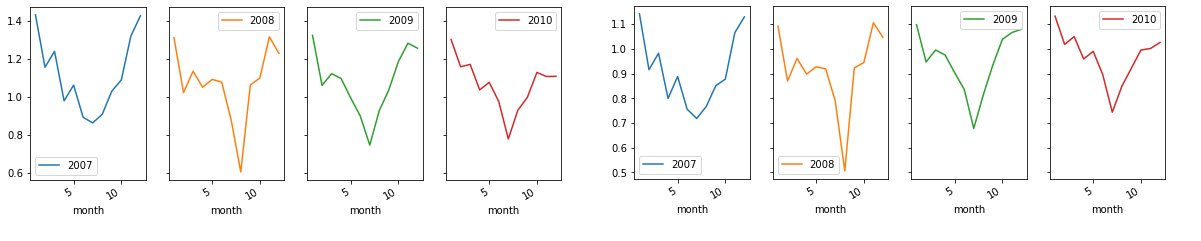

In [11]:
Image("yearlylinefin.png")

# Przygotowanie ogólnego zbioru

In [12]:
df.shape

(2075259, 9)

In [13]:
df = df.dropna()

In [14]:
df.shape # usunięto 25979 Nanów (czyli 1.25%)

(2049280, 9)

In [15]:
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y')
df["Time"]  = pd.to_datetime(df["Time"])
df["Global_active_power"] = df["Global_active_power"].astype('float')
df["Sub_metering_1"] = df["Sub_metering_1"].astype('float')
df["Sub_metering_2"] = df["Sub_metering_2"].astype('float')
df["Sub_metering_3"] = df["Sub_metering_3"].astype('float')

In [16]:
df = df.drop(['Global_reactive_power','Voltage','Global_intensity'], axis=1)

In [17]:
df.dtypes

Date                   datetime64[ns]
Time                   datetime64[ns]
Global_active_power           float64
Sub_metering_1                float64
Sub_metering_2                float64
Sub_metering_3                float64
dtype: object

# Analiza szeregów czasowych

#### Analiza szeregów czasowych ma dwa główne cele: 

1. Wykrywanie natury zjawiska reprezentowanego przez sekwencję obserwacji
2. Przewidywanie przyszłych wartości szeregu czasowego (prognozowanie)

#### Szeregi czasowe mogą być:
1. Stacjonarne (nie ma trendu ani sezonowości, średnie i odchylenia standardowe są stałe)
2. Niestacjonarne (istnieje trend i/lub sezonowość)

# Analiza zużycia prądu dla danych miesięcznych

In [18]:
dfm = df.groupby(pd.Grouper(key='Date', freq='1M')).sum()
dfm.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date,,,,
2006-12-31,41813.282,27460.0,48712.0,162951.0
2007-01-31,69011.862,56433.0,79274.0,329578.0
2007-02-28,56488.886,47584.0,64604.0,270274.0
2007-03-31,58862.192,60769.0,104762.0,290361.0
2007-04-30,35181.466,42078.0,38417.0,189503.0


In [19]:
dfm.index

DatetimeIndex(['2006-12-31', '2007-01-31', '2007-02-28', '2007-03-31',
               '2007-04-30', '2007-05-31', '2007-06-30', '2007-07-31',
               '2007-08-31', '2007-09-30', '2007-10-31', '2007-11-30',
               '2007-12-31', '2008-01-31', '2008-02-29', '2008-03-31',
               '2008-04-30', '2008-05-31', '2008-06-30', '2008-07-31',
               '2008-08-31', '2008-09-30', '2008-10-31', '2008-11-30',
               '2008-12-31', '2009-01-31', '2009-02-28', '2009-03-31',
               '2009-04-30', '2009-05-31', '2009-06-30', '2009-07-31',
               '2009-08-31', '2009-09-30', '2009-10-31', '2009-11-30',
               '2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30'],
              dtype='datetime64[ns]', name='Date', freq='M')

## Seasonal decomposition w celu sprawdzenia trendów/ sezonowości graficznie

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

power_sd = seasonal_decompose(dfm['Global_active_power'], model='add')
sub1_sd = seasonal_decompose(dfm['Sub_metering_1'], model='add')
sub2_sd = seasonal_decompose(dfm['Sub_metering_2'], model='add')
sub3_sd = seasonal_decompose(dfm['Sub_metering_3'], model='add')

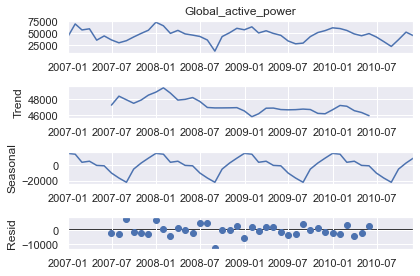

In [21]:
power_sd.plot();

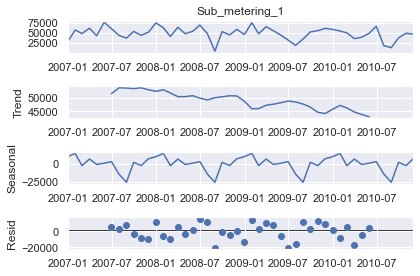

In [22]:
sub1_sd.plot();

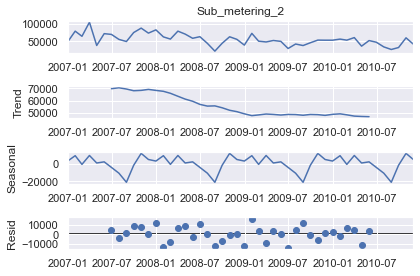

In [23]:
sub2_sd.plot();

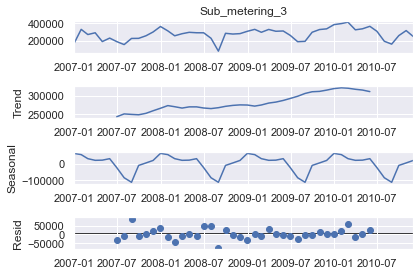

In [24]:
sub3_sd.plot();

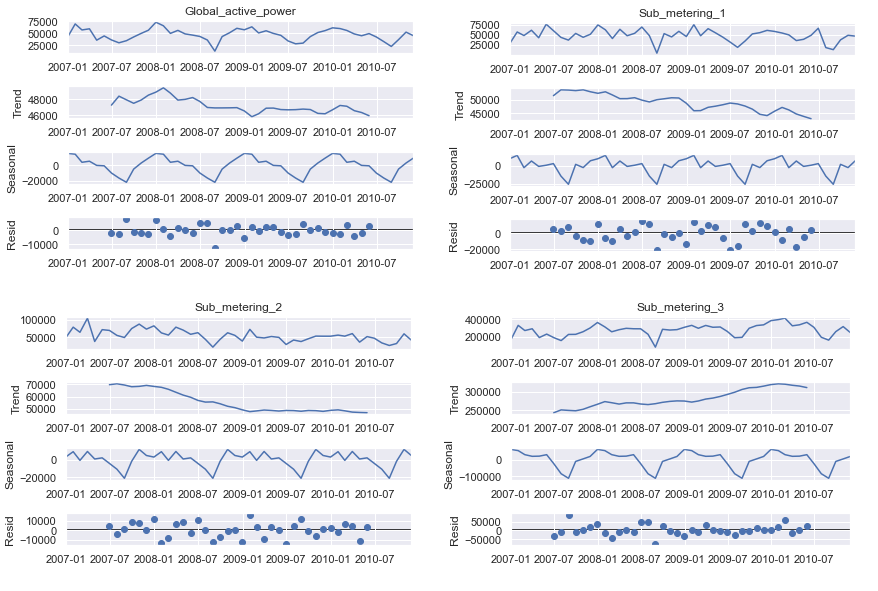

In [25]:
Image("globalos.png")

## Porównanie modeli 
#### Simple Exponential Smoothing (SES) vs Triple Exponential Smoothing (TES)

In [26]:
span = 12 #liczba miesięcy
alpha = 2/(span+1)

#dfd.index = pd.DatetimeIndex(dfd.index).to_period('D')

# SES dla wszystkich zmiennych
dfm['SES_power'] = SimpleExpSmoothing(dfm['Global_active_power']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub1'] = SimpleExpSmoothing(dfm['Sub_metering_1']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub2'] = SimpleExpSmoothing(dfm['Sub_metering_2']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
dfm['SES_sub3'] = SimpleExpSmoothing(dfm['Sub_metering_3']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

# TES dla power i sub3, bo ma to sens od razu na pierwszy rzut oka
dfm['TES_power'] = ExponentialSmoothing(dfm['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dfm['TES_sub3'] = ExponentialSmoothing(dfm['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

# dodaję TES dla tych też, bo ciekawy wynik seasonal decomposition (patrz sezonowość)
dfm['TES_sub1'] = ExponentialSmoothing(dfm['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
dfm['TES_sub2'] = ExponentialSmoothing(dfm['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

### SES

Pojedyncze wygładzanie wykładnicze (Simple Exponential Smoothing), w skrócie SES, to metoda prognozowania szeregów czasowych dla danych jednoczynnikowych bez trendu lub sezonowości. Wymaga pojedynczego parametru alfa (a), nazywanego również współczynnikiem wygładzania (smoothing factor).

### TES

Potrójne wygładzanie wykładnicze (Triple Exponential Smoothing), w skrócie TES, jest rozszerzeniem wygładzania wykładniczego, które dodatkowo obsługuje sezonowość dla jednowymiarowych szeregów czasowych. Ta metoda jest czasami nazywana wygładzaniem wykładniczym Holta-Wintersa, nazwana na cześć dwóch współtwórców metody: Charlesa Holta i Petera Wintersa.

Oprócz współczynników wygładzania alfa i beta dodany jest nowy parametr o nazwie gamma (g), który kontroluje czynnik sezonowy.

Podobnie jak w przypadku trendu, sezonowość można modelować jako proces addytywny lub multiplikatywny.

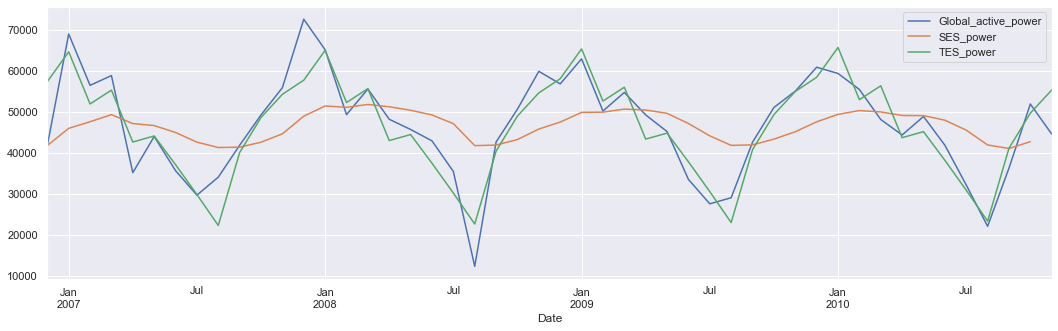

In [27]:
# Global active power - widzimy sezonowość, wzrost zużycia prądu w miesiącach zimowych i spadek w miesiącach letnich


dfm[['Global_active_power','SES_power','TES_power']].plot(figsize=(18,5));

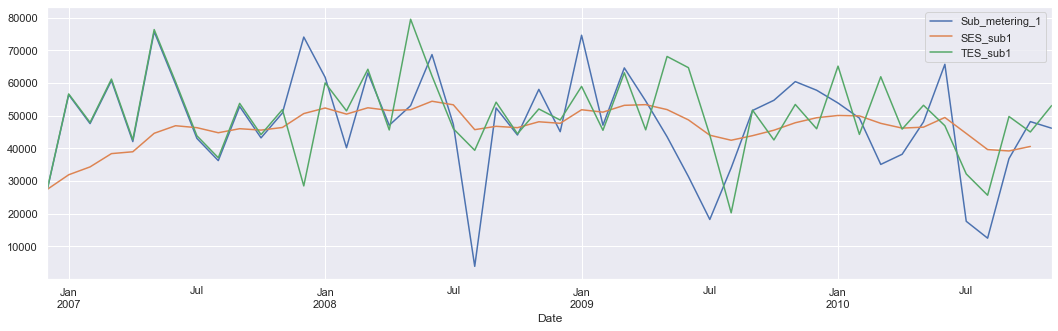

In [28]:
# Zużycie prądu w kuchni nie wydaje się być na pierwszy rzut oka cykliczne.

# *Kuchnia zawiera zmywarkę, piekarnik i mikrofalę (kuchenka jest gazowa).


dfm[['Sub_metering_1','SES_sub1','TES_sub1']].plot(figsize=(18,5));

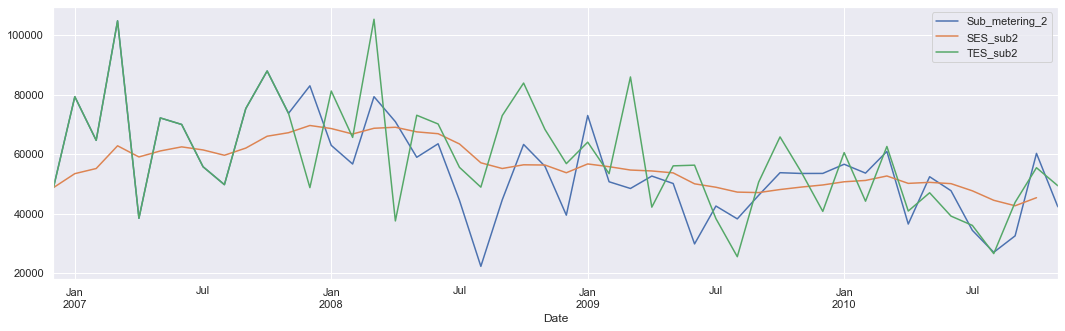

In [29]:
# Zużycie prądu w pralni również nie wydaje się być cykliczne.

# *Pralnia zawiera pralkę, suszarkę, lodówkę i światło.

dfm[['Sub_metering_2','SES_sub2','TES_sub2']].plot(figsize=(18,5));

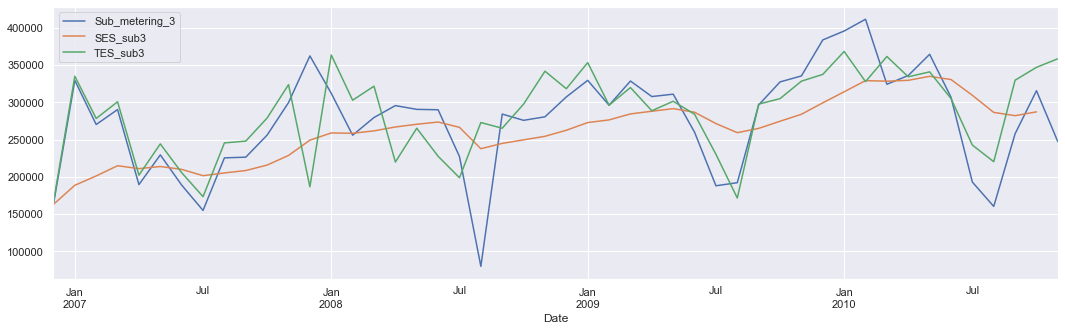

In [30]:
# Zużycie prądu dla elektrycznego podgrzewacza wody i klimatyzatora (Sub3) wydaje się być cykliczne - większe zużycie w miesiącach zimowych.


dfm[['Sub_metering_3','SES_sub3','TES_sub3']].plot(figsize=(18,5));

## Prognozowanie danych miesięcznych zużycia prądu z wykorzystaniem Triple Exponential Smoothing dla global active power i sub3

### Global active power - TES

In [31]:
# dzielę model na treningowy i testowy, by dokonać estymacji działania modelu poprzez błąd MAE i RMSE
# ramki ze wszystkimi kolumnami, żeby potem użyć do modelowania dalszych zmiennych
month_train = dfm.iloc[:36]
month_test = dfm.iloc[36:]

In [125]:
# sprawdzam skuteczność modelu TES dla Global active power 

power_train_model = ExponentialSmoothing(month_train['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = power_train_model.forecast(12).rename('TES_power_Forecast')

# ewaluacja na podstawie błędów; błąd musi być mniejszy niż std
print(mean_absolute_error(month_test['Global_active_power'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Global_active_power'],test_predictions)))
print(month_test['Global_active_power'].std())

5014.1911358268235
6458.025172875721
11336.01333086247


In [126]:
# Ewaluacja na podstawie błędów:
# Mean Absolute Error (MEA) oraz Root Mean Square Error (RMSE) są mniejsze niż Odchylenie Standardowe (SD)

print(mean_absolute_error(month_test['Global_active_power'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Global_active_power'],test_predictions)))
print(month_test['Global_active_power'].std())

5014.1911358268235
6458.025172875721
11336.01333086247


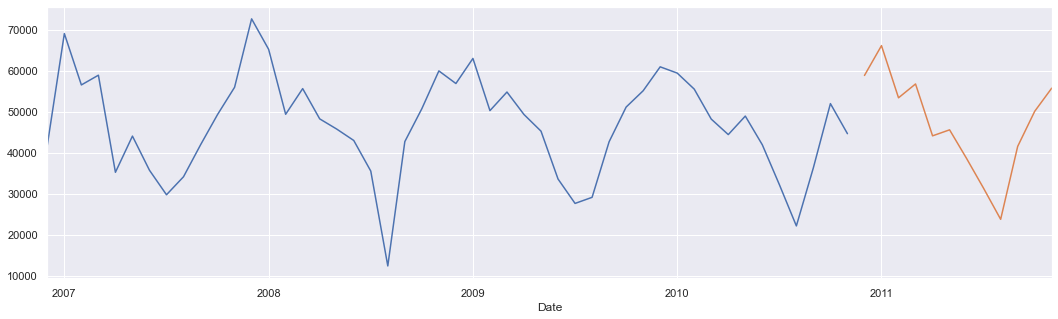

In [34]:
# Predykcja przyszłych danych (bez możliwości weryfikacji, trzeba zaufać powyższym obliczeniom, że dopasowanie jest dobre i dokona solidnej predykcji)

power_TES_model = ExponentialSmoothing(dfm['Global_active_power'],trend='add',seasonal='add',seasonal_periods=12).fit()
power_TES_predictions = power_TES_model.forecast(12)

dfm['Global_active_power'].plot(figsize=(18,5))
power_TES_predictions.plot();

### Sub3 - TES 

Analiza pomiaru z elektrycznego podgrzewacza wody i klimatyzatora

In [89]:
# sprawdzam skuteczność modelu TES dla sub3 

sub3_train_model = ExponentialSmoothing(month_train['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = sub3_train_model.forecast(12).rename('TES_sub3_Forecast')

print(mean_absolute_error(month_test['Sub_metering_3'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_3'],test_predictions)))
print(month_test['Sub_metering_3'].std())

46340.23198129074
54511.06958645323
79706.64793060446


46340.23198129074
54511.06958645323
79706.64793060446


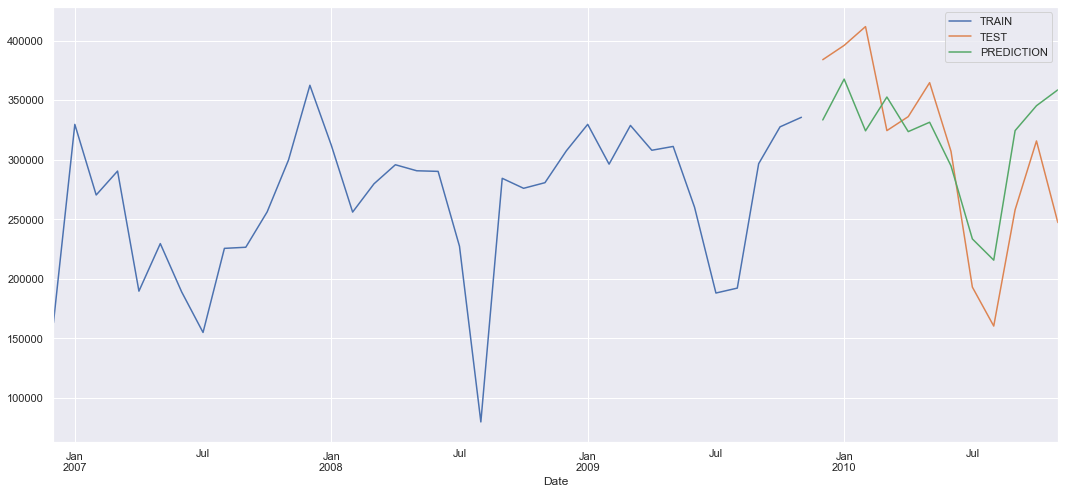

In [90]:
# Ewaluacja na podstawie błędów:
# Mean Absolute Error (MEA) oraz Root Mean Square Error (RMSE) są mniejsze niż Odchylenie Standardowe (SD)

print(mean_absolute_error(month_test['Sub_metering_3'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_3'],test_predictions)))
print(month_test['Sub_metering_3'].std())

month_train['Sub_metering_3'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_3'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

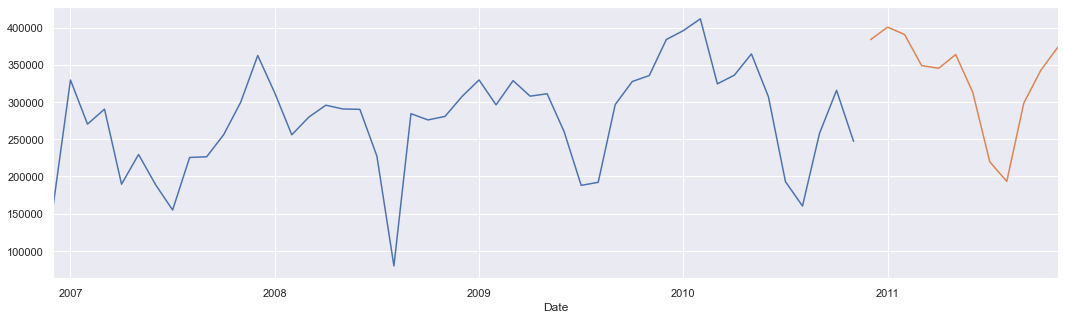

In [37]:
# Predykcja przyszłych danychedykcji)

sub3_TES_model = ExponentialSmoothing(dfm['Sub_metering_3'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub3_TES_predictions = sub3_TES_model.forecast(12)

dfm['Sub_metering_3'].plot(figsize=(18,5))
sub3_TES_predictions.plot();

### Sub1 - SES

Analiza pomiaru z kuchni składającej się ze zmywarki, piekarnika i kuchenki mikrofalowej.

In [38]:
span = 12
alpha = 2/(span+1)

sub1_train_model = SimpleExpSmoothing(month_train['Sub_metering_1']).fit(smoothing_level=alpha,optimized=False)
test_predictions = sub1_train_model.forecast(12).rename('SES_sub1_Forecast')


print(mean_absolute_error(month_test['Sub_metering_1'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_1'],test_predictions)))
print(month_test['Sub_metering_1'].std())

11377.583333333334
15806.473273996042
15519.070433297104


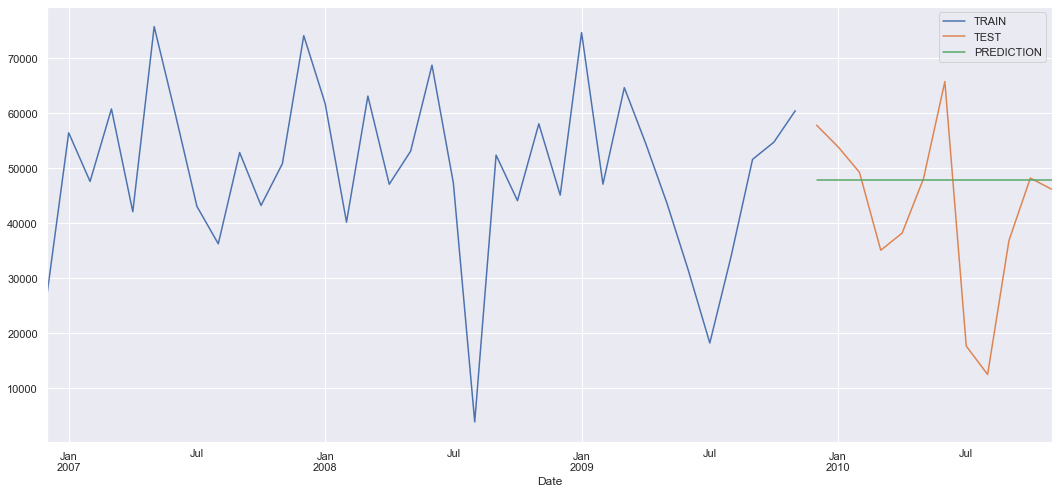

In [39]:
# Duże błędy (niemalże takie jak odchylenie standardowe). Predykcja nie jest dobra (trzeba użyć innego modelu).

month_train['Sub_metering_1'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_1'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

### Sub 2 SES

Analiza pomiaru z pralni, w której znajduje się pralka, suszarka bębnowa, lodówka i oświetlenie.

In [40]:
span = 12
alpha = 2/(span+1)

sub2_train_model = SimpleExpSmoothing(month_train['Sub_metering_2']).fit(smoothing_level=alpha,optimized=False)
test_predictions = sub2_train_model.forecast(12).rename('SES_sub2_Forecast')

from sklearn.metrics import mean_squared_error,mean_absolute_error

print(mean_absolute_error(month_test['Sub_metering_2'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_2'],test_predictions)))
print(month_test['Sub_metering_2'].std())

9736.083333333334
11349.987445271148
11573.986674343407


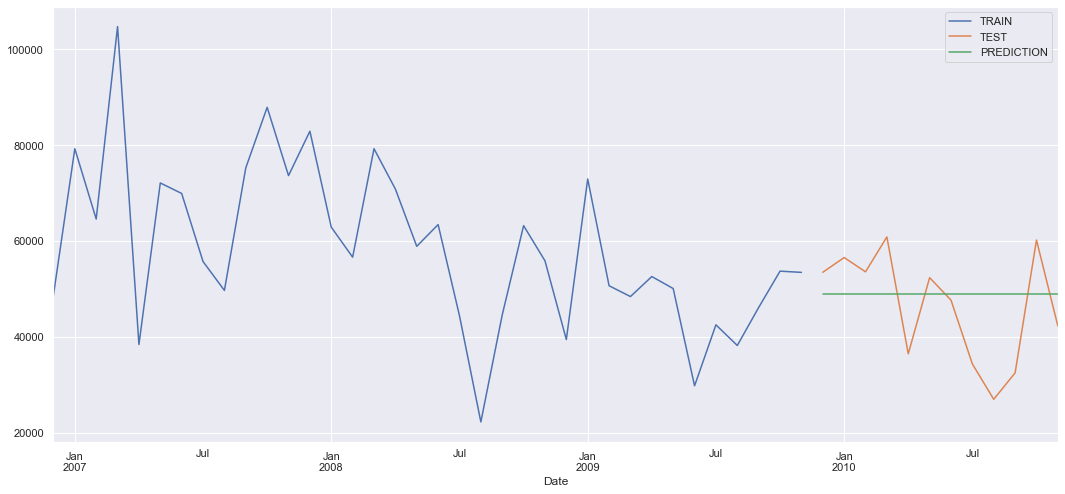

In [41]:
# Duże błędy (niemalże takie jak odchylenie standardowe). Predykcja nie jest dobra (trzeba użyć innego modelu).

month_train['Sub_metering_2'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_2'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

### Sprawdzenie skuteczności modeli TES dla Sub1 i Sub2

In [42]:
# sprawdzam skuteczność modelu TES dla Sub1

sub3_train_model = ExponentialSmoothing(month_train['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = sub3_train_model.forecast(12).rename('TES_sub1_Forecast')

print(mean_absolute_error(month_test['Sub_metering_1'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_1'],test_predictions)))
print(month_test['Sub_metering_1'].std())

11801.924592079706
13470.928319341303
15519.070433297104


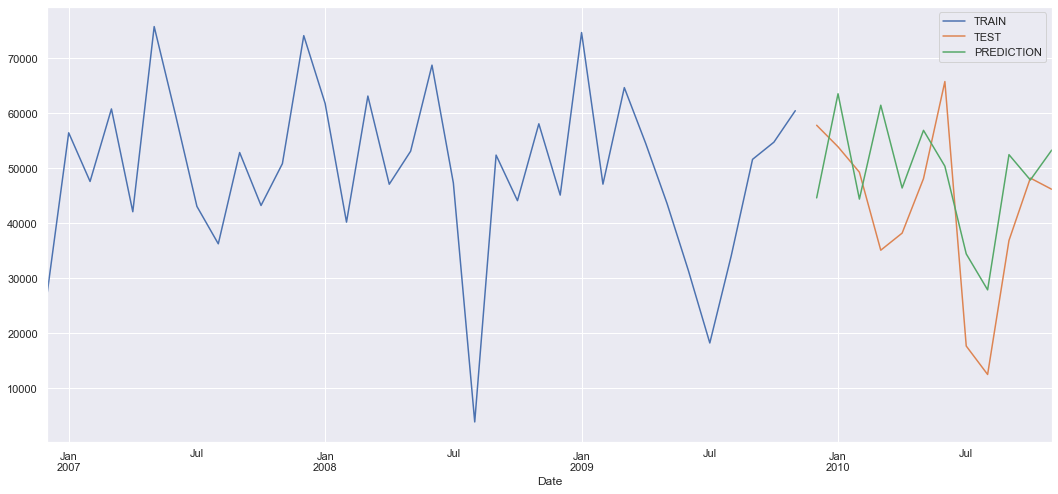

In [43]:
# Błędy są mniejsze niż przy SES
# Mean absolute error (MEA) oraz Root Mean Square Error (RMSE) są większe niż Odchylenie Standardowe (SD)

month_train['Sub_metering_1'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_1'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

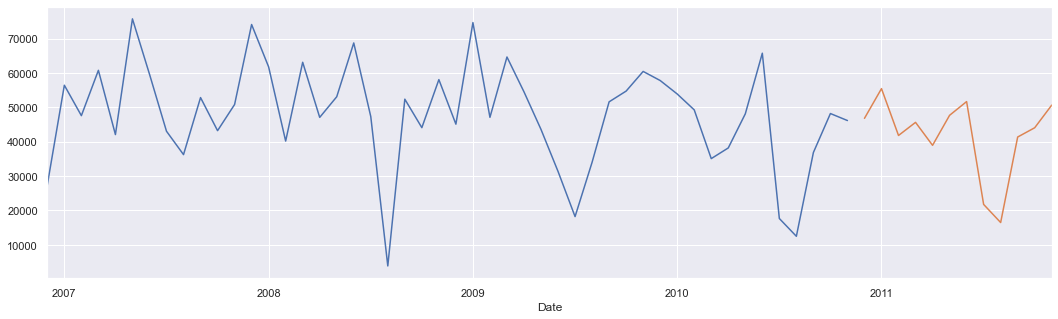

In [44]:
sub1_TES_model = ExponentialSmoothing(dfm['Sub_metering_1'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub1_TES_predictions = sub1_TES_model.forecast(12)

dfm['Sub_metering_1'].plot(figsize=(18,5))
sub1_TES_predictions.plot();

In [45]:
# sprawdzam skuteczność modelu TES dla Sub2

sub3_train_model = ExponentialSmoothing(month_train['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = sub3_train_model.forecast(12).rename('TES_sub2_Forecast')

print(mean_absolute_error(month_test['Sub_metering_2'],test_predictions))
print(np.sqrt(mean_squared_error(month_test['Sub_metering_2'],test_predictions)))
print(month_test['Sub_metering_2'].std())

5763.564745905795
6953.3088238305
11573.986674343407


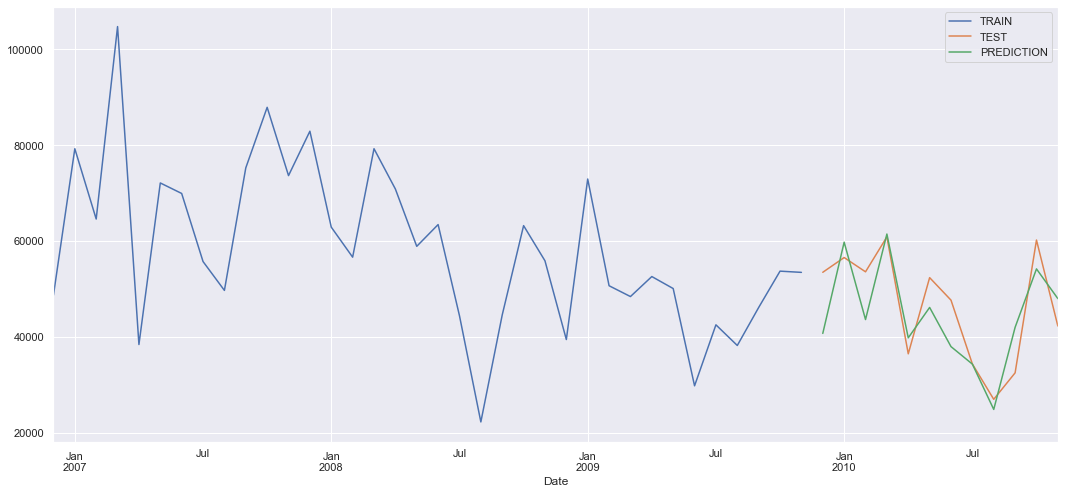

In [46]:
# Błędy są mniejsze niż przy SES
# Mean absolute error (MEA) oraz Root Mean Square Error (RMSE) są większe niż Odchylenie Standardowe (SD)

month_train['Sub_metering_2'].plot(legend=True,label='TRAIN')
month_test['Sub_metering_2'].plot(legend=True,label='TEST',figsize=(18,8))
test_predictions.plot(legend=True,label='PREDICTION');

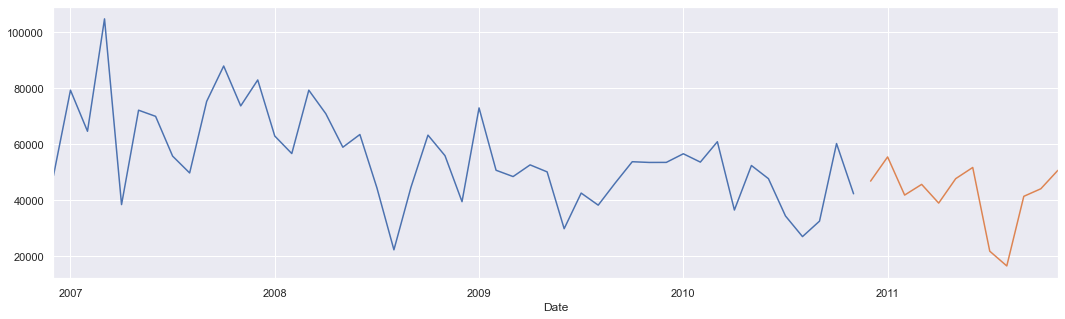

In [47]:
sub2_TES_model = ExponentialSmoothing(dfm['Sub_metering_2'],trend='add',seasonal='add',seasonal_periods=12).fit()
sub2_TES_predictions = sub1_TES_model.forecast(12)

dfm['Sub_metering_2'].plot(figsize=(18,5))
sub2_TES_predictions.plot();

### Wniosek:

TES jest lepszym wyborem niż SES dl zmiennej GAP i Sub3

## Testowanie stacjonarności
### Dickey-Fuller Test

In [48]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [49]:
adf_test(dfm['Global_active_power'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.597298e+00
p-value                 6.874210e-09
# lags used             7.000000e+00
# observations          4.000000e+01
critical value (1%)    -3.605565e+00
critical value (5%)    -2.937069e+00
critical value (10%)   -2.606986e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [50]:
adf_test(dfm['Sub_metering_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.669254e+00
p-value                 9.001166e-07
# lags used             0.000000e+00
# observations          4.700000e+01
critical value (1%)    -3.577848e+00
critical value (5%)    -2.925338e+00
critical value (10%)   -2.600774e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [51]:
adf_test(dfm['Sub_metering_2'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.734022
p-value                  0.000073
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [52]:
adf_test(dfm['Sub_metering_3'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.989384
p-value                  0.001467
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Testy pokazały, że wszystkie zmienne są stacjonarne, wbrew temu co pokazały wykresy seasonal decomposition.

## Prognozowanie danych miesięcznych zużycia prądu z wykorzystaniem ARIMA i SARIMA 

### ARIMA


ARIMA to akronim, który oznacza AutoRegressive Integrated Moving Average. Jest to uogólnienie prostszej auto-regresywnej średniej kroczącej i dodaje pojęcie integracji.

Autoregresja (AR): model, który wykorzystuje zależność między obserwacją a pewną liczbą obserwacji opóźnionych (lagged values).

Integracja (I): różnicowanie surowych obserwacji, np. odejmowanie obserwacji od obserwacji z poprzedniego przedziału czasowego, aby uzyskać stacjonarność szeregów czasowych.

Średnia krocząca (MA): model, który wykorzystuje zależność między obserwacją a błędem resztowym (residual error) z modelu średniej ruchomej zastosowanego do obserwacji opóźnionych.

Każdy z tych komponentów jest wyraźnie określony w modelu jako parametr. Stosowany jest standardowy zapis ARIMA (p, d, q), w którym parametry są zastępowane wartościami całkowitymi.

p: liczba obserwacji opóźnionych zawartych w modelu, zwana także kolejnością opóźnień

d: Liczba różnic między surowymi obserwacjami, zwana także stopniem różnicowania

q: Rozmiar okna średniej ruchomej, nazywany również porządkiem średniej ruchomej

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

### SARIMA

Problem z ARIMA polega na tym, że nie obsługuje danych sezonowych, czyli szeregu czasowego z powtarzającym się cyklem.

ARIMA oczekuje danych, które nie są sezonowe lub mają usuniętą sezonowość. Alternatywą dla danych, które charakteryzuje sezonowość jest użycie SARIMY.

Sezonowa autoregresywna zintegrowana średnia ruchoma (SARIMA lub Seasonal ARIMA), to rozszerzenie ARIMA, które obsługuje jednowymiarowe dane szeregów czasowych ze składnikiem sezonowym.

Konfiguracji wymagają te same parametry jak la ARIMA, czyli p, d i q. Dodatkowo, SARIMA wymaga ustawienia czterech parametrów sezonowych.

P: Seasonal autoregressive order

D: Seasonal difference order

Q: Seasonal moving average order

m: The number of time steps for a single seasonal period

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle.

ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

An alternative is to use SARIMA.

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

## ARIMA dla global active power

In [53]:
stepwise_fit = auto_arima(dfm['Global_active_power'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=763.929, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=761.683, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=761.652, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=761.537, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.752, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=763.674, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=763.673, Time=0.16 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=765.601, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=760.400, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=759.873, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=762.569, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.474 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -378.876
Date:                  Sun, 14 Mar 2021   AIC                            759.752
Time:                          12:10:58   BIC                            761.336
Sample:                               0   HQIC                           760.305
                                   - 48                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.652e+07   1.12e+07      6.857      0.000    5.46e+07    9.84e+07
===================================================================================
Ljung-Box (Q):                       67.23   Jarque-Bera (JB):                14.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             0.79
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
auto_arima(dfm['Global_active_power'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -509.417
Date:                Sun, 14 Mar 2021   AIC                           1024.835
Time:                        12:10:58   BIC                           1030.449
Sample:                             0   HQIC                          1026.956
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.925e+04   5285.137      3.642      0.000    8888.788    2.96e+04
ar.L1          0.5849      0.119      4.930      0.000       0.352       0.817
sigma2      9.763e+07      0.206   4.74e+08      0.000    9.76e+07    9.76e+07
===================================================================================
Ljung-Box (Q):                       76.27   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.00   Prob(JB):                         0.66
Heteroskedasticity (H):               0.47   Skew:                            -0.11
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.05e+24. Standard errors may be unstable.
"""

In [55]:
# dzielę model na treningowy i testowy, by dokonać estymacji działania modelu poprzez błąd MAE i RMSE
# ramki ze wszystkimi kolumnami, żeby potem użyć do modelowania dalszych zmiennych
month_train = dfm.iloc[:36]
month_test = dfm.iloc[36:]

In [56]:
model_power_ARIMA = ARIMA(month_train['Global_active_power'],order=(1,0,0))
results = model_power_ARIMA.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARMA Model Results                              
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   36
Model:                      ARMA(1, 0)   Log Likelihood                -384.067
Method:                        css-mle   S.D. of innovations          10348.217
Date:                 Sun, 14 Mar 2021   AIC                            774.133
Time:                         12:10:58   BIC                            778.884
Sample:                     12-31-2006   HQIC                           775.791
                          - 11-30-2009                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      4.706e+04   3711.623     12.680      0.000    3.98e+04    5.43e+04
ar.L1.Global_active_power     0.5503      0.136      4.055      0.000       0.284       0.816
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8171           +0.0000j            1.8171            0.0000
-----------------------------------------------------------------------------
"""

In [57]:
# sprawdzam drugi model dla tych danych zgodnie z powyższymi sugestiami, ale wychodzi do śmieci,
# więc wybieram (1,0,0)

model_power_ARIMA2 = ARIMA(month_train['Global_active_power'],order=(0,1,0))
results = model_power_ARIMA2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARIMA Model Results                               
=================================================================================
Dep. Variable:     D.Global_active_power   No. Observations:                   35
Model:                    ARIMA(0, 1, 0)   Log Likelihood                -377.887
Method:                              css   S.D. of innovations          11823.265
Date:                   Sun, 14 Mar 2021   AIC                            759.773
Time:                           12:10:58   BIC                            762.884
Sample:                       01-31-2007   HQIC                           760.847
                            - 11-30-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        378.6960   1998.497      0.189      0.850   -3538.285    4295.677
==============================================================================
"""

In [58]:
start=len(month_train)
end=len(month_train)+len(month_test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Predictions')

[Text(0, 0.5, 'Global_active_power'), Text(0.5, 0, '')]

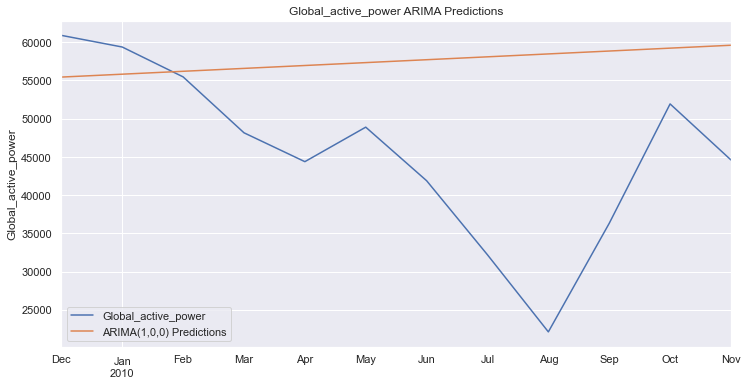

In [59]:
title = 'Global_active_power ARIMA Predictions'
ylabel = 'Global_active_power'
xlabel = '' # we don't really need a label here

ax = month_test['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [60]:
from statsmodels.tools.eval_measures import rmse

error = rmse(month_test['Global_active_power'], predictions)
print(f'ARIMA(1,0,0) RMSE Error: {error}')

ARIMA(1,0,0) RMSE Error: 16772.00451771889


### Błąd dla tego modelu (RMSE: 16772) jest dużo większy niż przy TES  (RMSE: 6856). ARIMA dla global active power nie oferuje dobrych predykcji.

#### Predykcja ARIMA w przyszłość

In [61]:
model = ARIMA(dfm['Global_active_power'],order=(1,0,0))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('ARIMA(1,0,0) Forecast')

[Text(0, 0.5, 'Global_active_power'), Text(0.5, 0, '')]

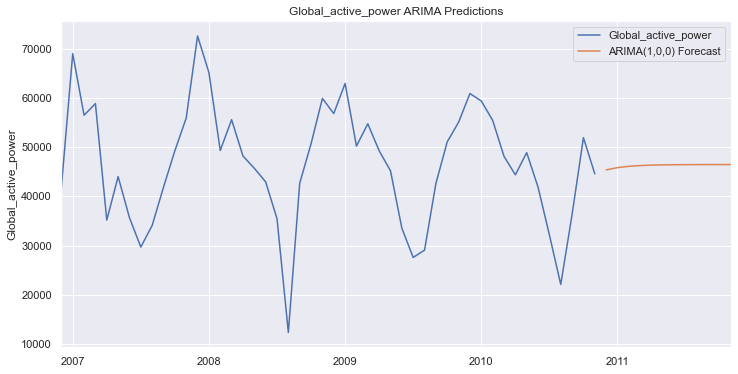

In [62]:
ax = dfm['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

## SARIMA dla global active power - czy model sezonowy będzie lepszy?

In [96]:
auto_arima(dfm['Global_active_power'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -505.595
Date:                            Sun, 14 Mar 2021   AIC                           1019.191
Time:                                    12:27:00   BIC                           1026.676
Sample:                                         0   HQIC                          1022.019
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.925e+04   8860.209      2.172      0.030    1881.775    3.66e+04
ar.L1          0.2926      0.207      1.414      0.158      -0.113       0.698
ar.S.L12       0.4195      0.212      1.978      0.048       0.004       0.835
sigma2      9.763e+07      2.321   4.21e+07      0.000    9.76e+07    9.76e+07
===================================================================================
Ljung-Box (Q):                       72.03   Jarque-Bera (JB):                 8.90
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.31   Skew:                            -0.08
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.01e+22. Standard errors may be unstable.
"""

In [95]:
model = SARIMAX(month_train['Global_active_power'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                Global_active_power   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -388.053
Date:                            Sun, 14 Mar 2021   AIC                            782.105
Time:                                    12:26:53   BIC                            786.856
Sample:                                12-31-2006   HQIC                           783.763
                                     - 11-30-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9367      0.078     12.083      0.000       0.785       1.089
ar.S.L12       0.3708      0.226      1.640      0.101      -0.072       0.814
sigma2      1.388e+08   5.91e-10   2.35e+17      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (Q):                       40.46   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.24   Prob(JB):                         0.81
Heteroskedasticity (H):               0.28   Skew:                             0.04
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.79e+33. Standard errors may be unstable.
"""

In [97]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Predictions')

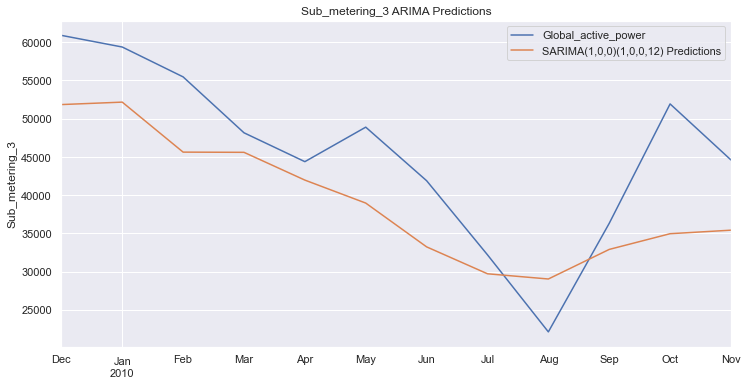

In [99]:
ax = month_test['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [102]:
error = rmse(month_test['Global_active_power'], predictions)
print(f'SARIMA(1,0,0)(1,0,0,12) RMSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,0,12) RMSE Error: 8443.364669


### Błąd dla SARIMA (RMSE: 8443) jest mniejszy niż dla ARIMA, ale większy niż dla TES. 

In [100]:
model = SARIMAX(dfm['Global_active_power'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Forecast')

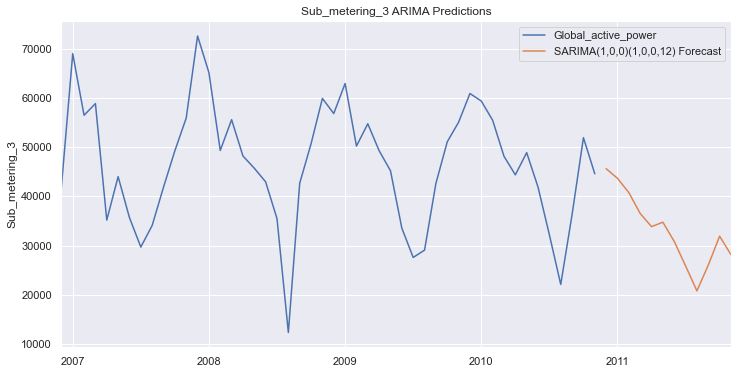

In [101]:
ax = dfm['Global_active_power'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Porównanie predykcji dla global active power

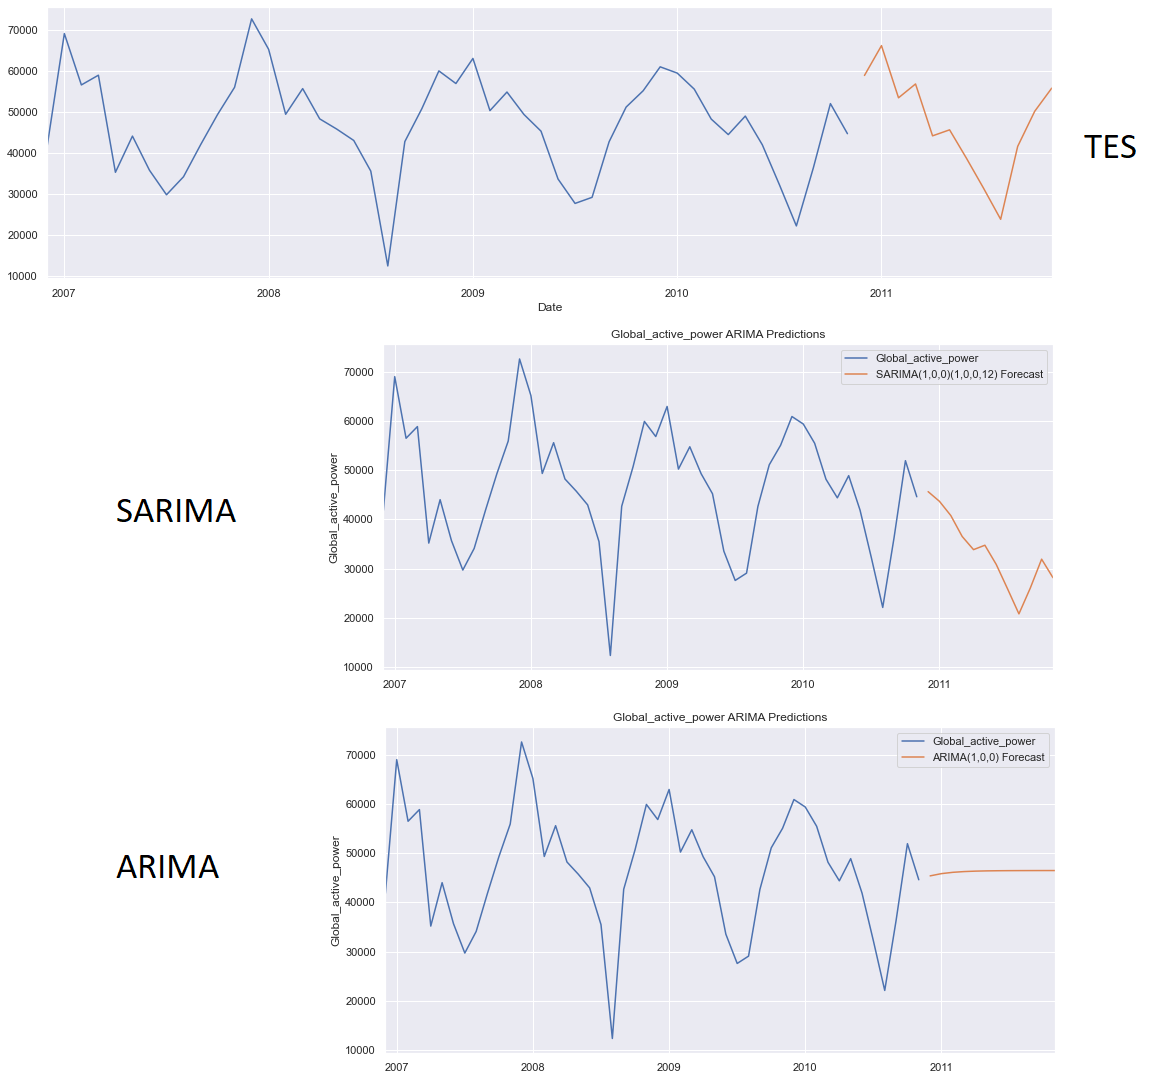

In [70]:
Image("MODELE-GAP.png")

## ARIMA dla sub3

In [112]:
stepwise_fit = auto_arima(dfm['Sub_metering_3'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=896.020, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=902.085, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=896.496, Time=0.14 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=900.363, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=906.679, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=902.328, Time=0.06 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=897.979, Time=0.33 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=897.924, Time=0.38 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=897.343, Time=0.19 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=894.681, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=900.554, Time=0.03 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=896.370, Time=0.22 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=896.672, Time=0.31 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -443.341
Date:                              Sun, 14 Mar 2021   AIC                            894.681
Time:                                      12:32:52   BIC                            901.015
Sample:                                           0   HQIC                           896.892
                                               - 48                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.784e+04   8272.506      2.156      0.031    1624.167    3.41e+04
ar.L1          0.6068      0.125      4.840      0.000       0.361       0.853
ma.S.L12      -0.6210      0.320     -1.938      0.053      -1.249       0.007
sigma2        3.2e+09      0.057   5.59e+10      0.000     3.2e+09     3.2e+09
===================================================================================
Ljung-Box (Q):                       24.34   Jarque-Bera (JB):                 5.88
Prob(Q):                              0.91   Prob(JB):                         0.05
Heteroskedasticity (H):               0.38   Skew:                            -0.12
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+26. Standard errors may be unstable.
"""

In [113]:
auto_arima(dfm['Sub_metering_3'],seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -594.361
Date:                Sun, 14 Mar 2021   AIC                           1194.722
Time:                        12:32:53   BIC                           1200.335
Sample:                             0   HQIC                          1196.843
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.38e+05    2.7e+04      5.111      0.000    8.51e+04    1.91e+05
ar.L1          0.4962      0.104      4.760      0.000       0.292       0.701
sigma2      3.174e+09      0.006   5.28e+11      0.000    3.17e+09    3.17e+09
===================================================================================
Ljung-Box (Q):                       31.76   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.82   Prob(JB):                         0.31
Heteroskedasticity (H):               1.03   Skew:                            -0.52
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+29. Standard errors may be unstable.
"""

In [114]:
start=len(month_train)
end=len(month_train)+len(month_test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Predictions')

[Text(0, 0.5, 'Sub_metering_3'), Text(0.5, 0, '')]

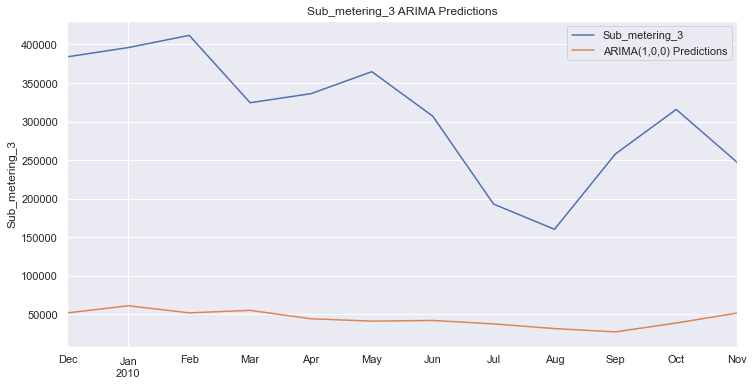

In [115]:
title = 'Sub_metering_3 ARIMA Predictions'
ylabel= 'Sub_metering_3'
xlabel='' # we don't really need a label here

ax = month_test['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [127]:
error = rmse(month_test['Sub_metering_3'], predictions)
print(f'ARIMA(1,0,0) RMSE Error: {error}')

ARIMA(1,0,0) RMSE Error: 64356.03047054328


### Błąd dla ARIMA (RMSE: 272867) jest znacznie wyższy niż dla TES (RMSE: 54511). 

#### SARIMA

In [117]:
auto_arima(dfm['Sub_metering_3'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -594.361
Date:                Sun, 14 Mar 2021   AIC                           1194.722
Time:                        12:32:55   BIC                           1200.335
Sample:                             0   HQIC                          1196.843
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.38e+05    2.7e+04      5.111      0.000    8.51e+04    1.91e+05
ar.L1          0.4962      0.104      4.760      0.000       0.292       0.701
sigma2      3.174e+09      0.006   5.28e+11      0.000    3.17e+09    3.17e+09
===================================================================================
Ljung-Box (Q):                       31.76   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.82   Prob(JB):                         0.31
Heteroskedasticity (H):               1.03   Skew:                            -0.52
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+29. Standard errors may be unstable.
"""

In [118]:
model = SARIMAX(month_train['Sub_metering_3'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Sub_metering_3   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -451.833
Date:                            Sun, 14 Mar 2021   AIC                            909.665
Time:                                    12:32:55   BIC                            914.416
Sample:                                12-31-2006   HQIC                           911.323
                                     - 11-30-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9594      0.064     14.962      0.000       0.834       1.085
ar.S.L12       0.1390      0.204      0.682      0.495      -0.260       0.538
sigma2      4.437e+09   7.47e-13   5.94e+21      0.000    4.44e+09    4.44e+09
===================================================================================
Ljung-Box (Q):                       26.03   Jarque-Bera (JB):                 6.78
Prob(Q):                              0.86   Prob(JB):                         0.03
Heteroskedasticity (H):               0.34   Skew:                             0.49
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.97e+38. Standard errors may be unstable.
"""

In [119]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Predictions')

In [120]:
error = rmse(month_test['Sub_metering_3'], predictions)
print(f'SARIMA(1,0,0)(1,0,0,12) RMSE Error: {error:11.10}')

SARIMA(1,0,0)(1,0,0,12) RMSE Error: 64356.03047


#### TES znowu wygrywa! robię jednak predykcję

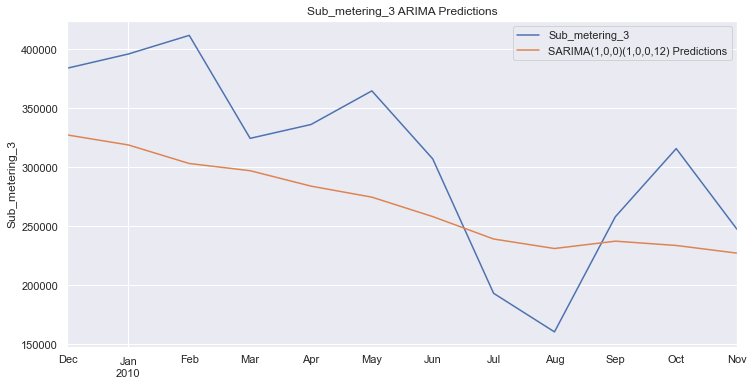

In [121]:
ax = month_test['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Błąd dla SARIMA (RMSE: 64356) jest wyższy niż dla TES (RMSE: 54511). 

In [124]:
model = SARIMAX(dfm['Sub_metering_3'],order=(1,0,0),seasonal_order=(1,0,0,12))
results = model.fit()
fcast = results.predict(len(dfm),len(dfm)+11,typ='levels').rename('SARIMA(1,0,0)(1,0,0,12) Forecast')

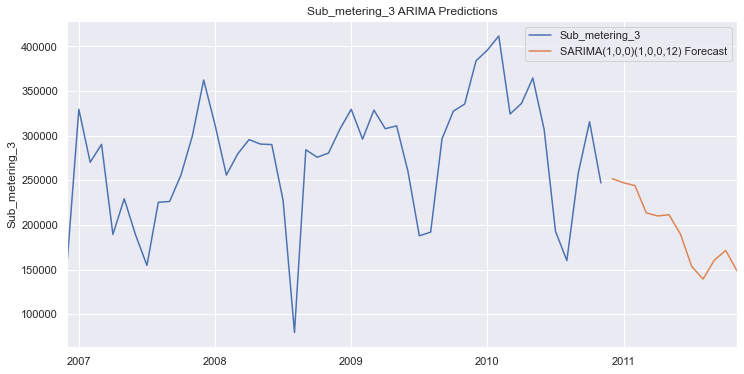

In [123]:
ax = dfm['Sub_metering_3'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Porównanie predykcji dla Sub-metering 3

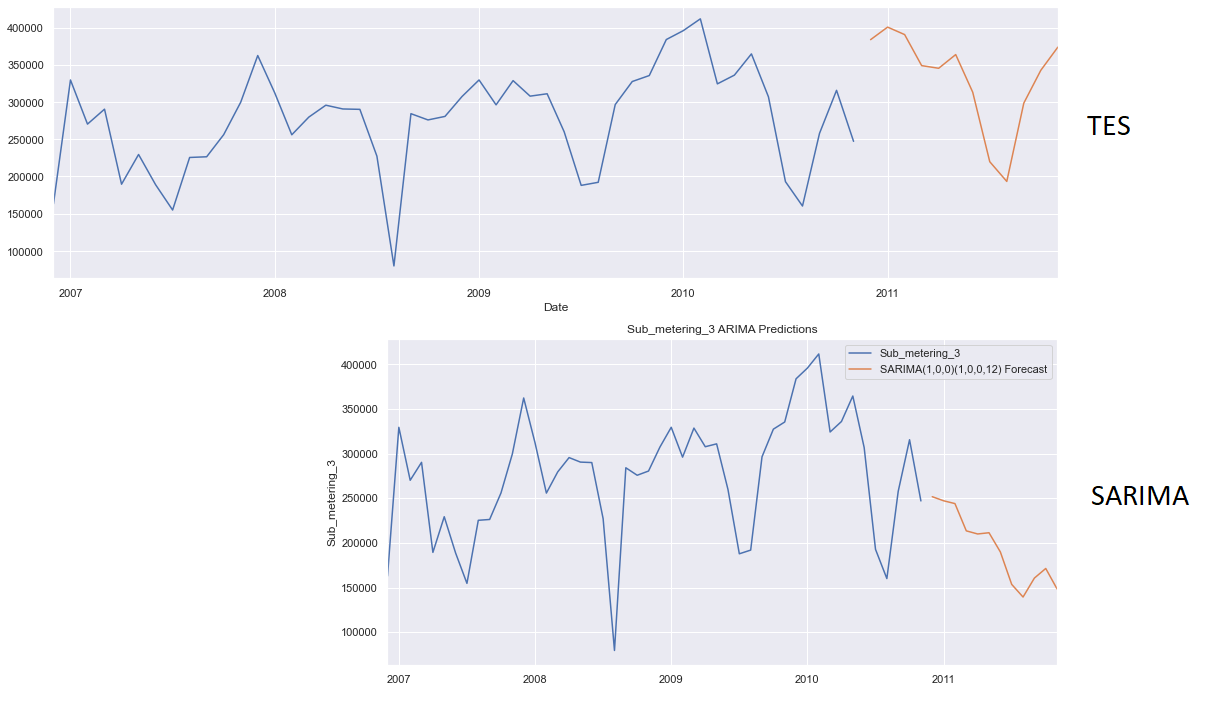

In [130]:
Image("MODELE_SUB3.png")

## Global active power

#### Triple Exponential Smoothing model

MAE: 3731.284726483131

RMSE: 4963.211711644529

STD: 8032.142871064464

#### ARIMA model

MAE: 6123.6291710656105

RMSE: 7396.932332961201

STD: 8032.142871064464

#### SARIMA model

MAE: 6451.903237178051

RMSE: 7036.702994387678

STD: 8032.142871064464

## Sub_metering3

#### Triple Exponential Smoothing model
MAE: 41216.35433037322

RMSE: 50489.751190351635

STD: 68254.66945909047

####  ARIMA model
MAE: 247072.7839807983

RMSE: 254607.6462463977

STD: 68254.66945909047

#### SARIMA model
MAE: 56474.90758380209

RMSE: 61200.06337072529

STD: 68254.66945909047

## Wniosek: Prostszy model TES oferuje najlepszą predykcję zużycia prądu.